In [1]:
### Import bibliotek ###
SEED = 11

import os
import random as rn
import numpy as np
from tensorflow.random import set_seed

os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
set_seed(SEED)
rn.seed(SEED)


# manipulacja danymi
import pandas as pd
import numpy as np
import math

# przygotowanie danych
from sklearn.preprocessing import MinMaxScaler

# wizualizacja danych
import matplotlib.pyplot as plt

# sieć neuronowa
from keras.models import Sequential
from keras.layers import Dense, LSTM

import requests
import time
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import pprint
import numpy
from dateutil.relativedelta import relativedelta
import pickle

from sklearn.metrics import mean_absolute_percentage_error

In [2]:
def weightedmovingaverage(Data, period):
        weighted = []
        Data=numpy.array(Data)
        total = numpy.arange(1, period + 1, 1)
        matrix = Data[len(Data) - period: len(Data)]
        matrix = numpy.ndarray.flatten(matrix)
        matrix = total * matrix
        wma = (matrix.sum()) / (total.sum()) # WMA
        return wma

In [3]:
nazwa = 'ETH'

In [4]:
def get_crypto(nazwa):
  #o	decimal	Kurs otwarcia.
  #c	decimal	Kurs zamknięcia.
  #h	decimal	Najwyższa wartość kursu.
  #l	decimal	Najniższa wartość kursu.
  #v	decimal	Wygenerowany wolumen.
  #nazwa: BTC, ETH, itp...

  candleCloseT=[]
  candleMin=[]
  candleMax=[]
  dzien=[]
  df = pd.DataFrame()

  candleClose= pd.DataFrame()
  teraz=datetime.datetime.now()

  stop=teraz#-datetime.timedelta(days=1)
  stop=stop.strftime("%d/%m/%Y %H:%M:%S")

  start=datetime.datetime(2023, 1, 1) #teraz-datetime.timedelta(days=1)
  print(start)
  start = datetime.datetime.now()-relativedelta(months=12)
  print(start)
  stop=datetime.datetime.now()#start+relativedelta(months=6)



  stop=stop.strftime("%d/%m/%Y %H:%M:%S")
  start=start.strftime("%d/%m/%Y %H:%M:%S")

  start=datetime.datetime.strptime(start, "%d/%m/%Y %H:%M:%S").timestamp()*1000
  stop=datetime.datetime.strptime(stop, "%d/%m/%Y %H:%M:%S").timestamp()*1000
  start=str(start)[:-2]
  stop=str(stop)[:-2]
  url = "https://api.zonda.exchange/rest/trading/candle/history/"+nazwa+"-PLN/3600?from="+start+"&to="+stop
  querystring = {"from":start,"to":stop}
  response = requests.request("GET", url, params=querystring)
  candle=json.loads(response.text)['items']
  close=[]
  o_ = []
  candleMin=[]
  candleMax=[]
  dzien=[]
  vol = []
  for i in candle:
      close.append(float(i[1]['c']))
      o_.append(float(i[1]['o']))
      vol.append(float(i[1]['v']))
      #m=(float(i[1]['h'])+float(i[1]['l']))/2
      candleMin.append(float(i[1]['l']))
      candleMax.append(float(i[1]['h']))
      dzien.append(datetime.datetime.fromtimestamp(int(i[0])/1000))
  df = pd.concat([df, pd.DataFrame({'data': dzien, 'cena': close, 'op': o_, 'min': candleMin, 'max': candleMax, 'vol': vol})])
  #candleClose= pd.DataFrame(candleCloseT, columns=['cena'], index=dzien)

  df['shortEMA'] = df['cena'].ewm(span=12, adjust=False).mean()
  #calculate long EMA
  df['longEMA'] = df['cena'].ewm(span=26, adjust=False).mean()
  #calculate MACD line
  df['MACD'] = df['shortEMA'] - df['longEMA']
  #calculate signal line
  df['signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

  df['EMA_5'] = df['cena'].ewm(span=5, adjust=False).mean()
  df['WMA85']=df['min'].rolling(85).apply(lambda x: x[::-1].cumsum().sum() * 2 / 85 / (85 + 1))
  df['WMA75']=df['min'].rolling(75).apply(lambda x: x[::-1].cumsum().sum() * 2 / 75 / (75 + 1))
  df['signal_MACD'] = df['MACD']-df['signal']

  df = df.dropna(subset=['WMA85'])

  return df

In [5]:
df = get_crypto(nazwa)

2023-01-01 00:00:00
2023-03-26 12:39:36.480908


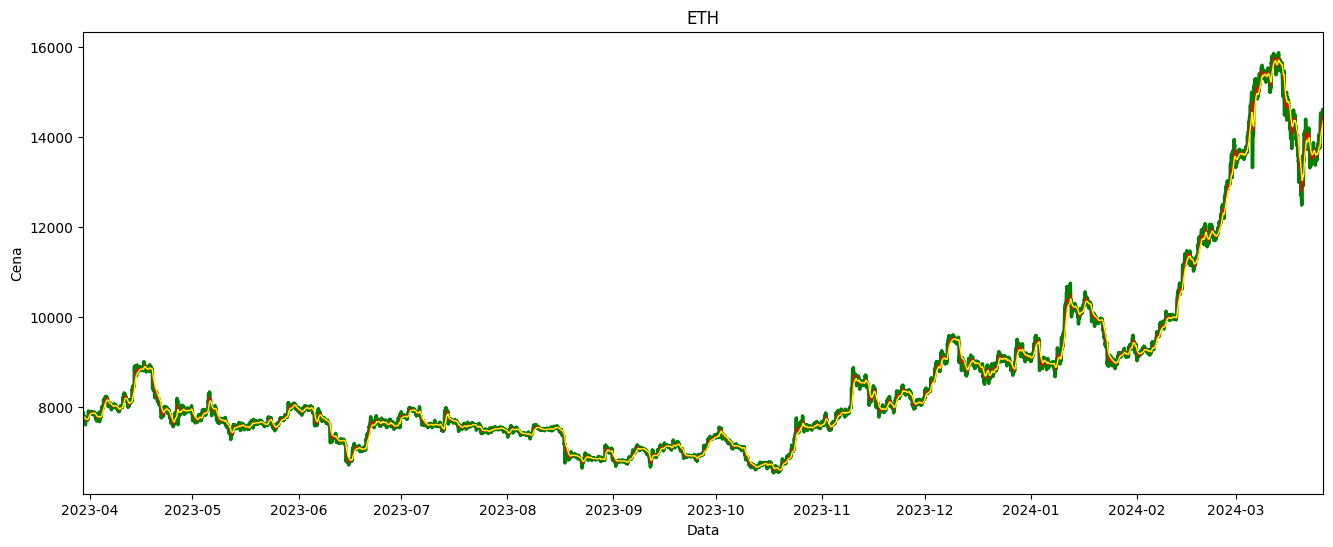

In [6]:
plt.figure(figsize=(16, 6))

plt.plot(df['data'], df['cena'], color='green', linewidth=2.5)
plt.plot(df['data'], df['shortEMA'], color='red', linewidth=1)
plt.plot(df['data'], df['longEMA'], color='yellow', linewidth=1)
plt.xlim(df['data'].min(), df['data'].max())
#plt.ylim(0, df['cena'].max()*1.05)
plt.xlabel('Data')
plt.ylabel('Cena')
plt.title('ETH')

plt.show()

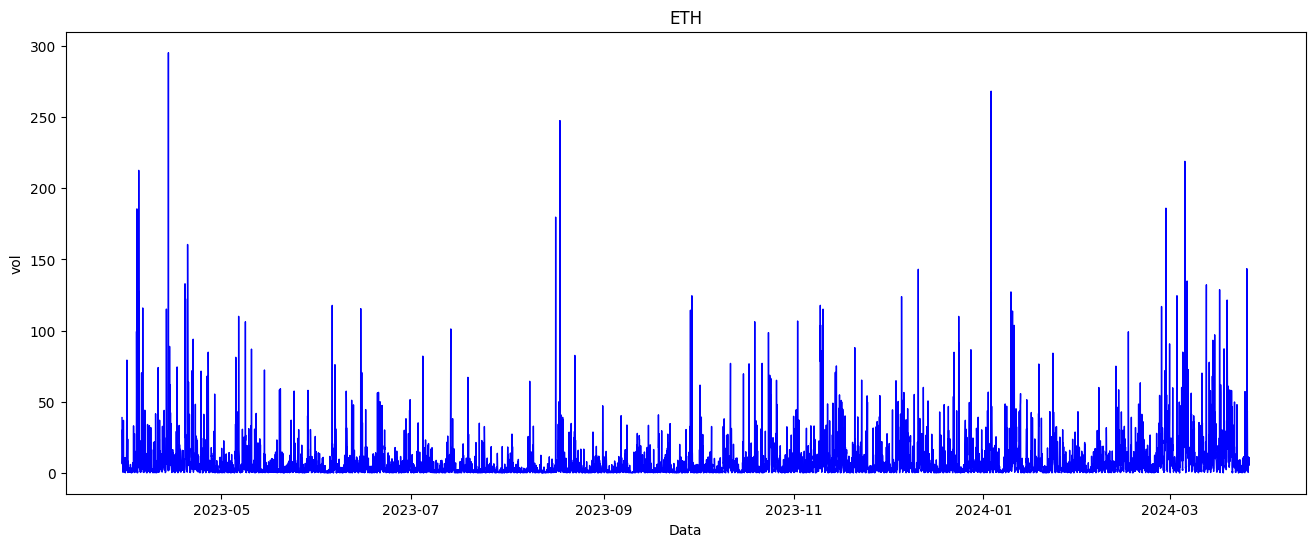

In [7]:
plt.figure(figsize=(16, 6))

plt.plot(df['data'], df['vol'], color='blue', linewidth=1)

plt.xlabel('Data')
plt.ylabel('vol')
plt.title('ETH')

plt.show()

In [8]:
# Skalowanie
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_data_array = scaler.fit_transform(df[['op', 'min', 'max', 'vol', 'shortEMA', 'longEMA',
       'MACD', 'signal', 'EMA_5', 'WMA85', 'WMA75', 'signal_MACD']])
y_data_scaled = scaler_y.fit_transform(np.array(df['cena'].values).reshape(-1, 1))

#scaler = MinMaxScaler(feature_range=(0, 1))
scaler_data = [scaler, scaler_y]
##scaler.fit(df[['o', 'min', 'max', 'vol', 'shortEMA', 'longEMA', 'MACD', 'signal', 'EMA_5', 'WMA85', 'WMA75', 'signal_MACD']])
pickle.dump(scaler_data, open('scaler_'+nazwa+'.pkl', 'wb'))

In [9]:
def prepare_data_future(train_data, y_data, n=0, h=24):
  #n - przedział godzin predykcji w przód
  #h - zakres godzin
  # Podział danych na X i y:
  X_ = []
  y_ = []

  for i in range(h, len(train_data)-n):
      X_.append(train_data[i-h:i, :])
      #y_.append(train_data[i + n, 0])
      y_.append(y_data[i + n, 0])
      #X_.append(train_data[i-24:i])
      #y_.append(train_data[i + n])

  print(len(X_), len(y_))
  X_ = np.array(X_)
  print(X_.shape)
  #X_ = np.reshape(X_, (X_.shape[0], X_.shape[1], 1))
  return X_, np.array(y_)

In [10]:
def ML_model(X_train, y_train):
  model_01 = Sequential()
  model_01.add(LSTM(40, return_sequences=True, input_shape=(X_train.shape[1], 12)))
  model_01.add(LSTM(40))
  model_01.add(Dense(40))
  model_01.add(Dense(20))
  model_01.add(Dense(20, activation='relu'))
  model_01.add(Dense(20))
  model_01.add(Dense(1))
  model_01.summary()
  model_01.compile(optimizer='adam', loss='mean_squared_error')
  history_1 = model_01.fit(X_train, y_train, batch_size=1, epochs=30)
  return model_01

In [ ]:
# Tworzenie zbioru treningowego
train_data_size=df.shape[0]
train_data = scaled_data_array[:train_data_size, :]
y_train = y_data_scaled[:train_data_size, :]
X_train_2h, y_train_2h = prepare_data_future(train_data, y_train, 2, 24)
X_train_5h, y_train_5h = prepare_data_future(train_data, y_train, 5, 24)

test_data = scaled_data_array[train_data_size:, :]
y_test = y_data_scaled[train_data_size:, :]
X_test_2h, y_test_2h = prepare_data_future(test_data, y_test, 2, 24)
X_test_5h, y_test_5h = prepare_data_future(test_data, y_test, 5, 24)

model_2h = ML_model(X_train_2h, y_train_2h)
model_5h = ML_model(X_train_5h, y_train_5h)

8344 8344
(8344, 24, 12)
8341 8341
(8341, 24, 12)
0 0
(0,)
0 0
(0,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 40)            8480      
                                                                 
 lstm_1 (LSTM)               (None, 40)                12960     
                                                                 
 dense (Dense)               (None, 40)                1640      
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                      

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
y_pred_2h = scaler_y.inverse_transform(model_2h.predict(X_test_2h))
y_pred_5h = scaler_y.inverse_transform(model_5h.predict(X_test_5h))
print('MAPE 2h', mean_absolute_percentage_error(y_test_2h, model_2h.predict(X_test_2h)))
print('MAPE 5h', mean_absolute_percentage_error(y_test_5h, model_5h.predict(X_test_5h)))

In [ ]:
model_2h.save('model_2h_'+nazwa+'.h5')
model_5h.save('model_5h_'+nazwa+'.h5')